# Price Data Download Notebook

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Literal
from tqdm import tqdm
from alpha_vantage.timeseries import TimeSeries

import src.utils.file_management as filemgmt

In [3]:
ROOT = Path().resolve().parent
DATA = ROOT / "data"
DAILY_PRICES = DATA / "daily_trading_prices"
MINUTELY_PRICES = DATA / "minutely_trading_prices"

AV_API_KEY_FILE = ROOT / "private" / "Alpha Vantage API Key.txt"
with open(AV_API_KEY_FILE) as file: AV_API_KEY = file.read()


## Download from Yfinance

In [36]:
def get_data_from_yahoo(ticker: str = '^GDAXI', duration_days: int = None, sampling_rate_minutes: int = None,
                        sampling_rate_days: int = 1, verbose=True, m_avg_days=[5, 30, 90],
                        price_column='Close', validation_split: float = None,
                        start_date=None, end_date=None, save_path=None) -> pd.DataFrame:
    """
    Data downloader utilising yfinance library.

    :param ticker: string, required, default = "^GDAXI" (DAX index)
        Specifies which stock's price data to download. Examples: "^IXIC" (Nasdaq), "^DJI" (Dow-Jones), "^GSPC" (S&P 500)
    :param duration_days: int, optional
        Amount of days to download data for. If not specified, downloads as much as possible.
    :param sampling_rate_minutes: int, optional
        Sampling rate of data in minutes. If not provided, utilises sampling_rate_days.
    :param sampling_rate_days: int, optional, default = 1
        Sampling rate of data in days.
    :param verbose: Bool, optional, default = True
        Specifies whether to print status messages e.g. regarding data coverage.
    :param m_avg_days: list of ints, optional, default = [5, 30, 90]
        Days to calculate moving averages for. If set to None, will calculate no moving averages.
    :param price_column: str, optional, default = "Close"
        Which of the downloaded columns to utilise as price data. Options: "Close", "High", "Low", "Open"
    :param validation_split: float, optional
        If provided, will return tuple with (training-split, validation-split) and the latter containing the respective ratio of latest data.
    :param start_date:
    :param end_date:
    :param save_path: str, optional, default = None
        File-title string defining repository where to save the downloaded data. If not provided, will not save the results.
    :return:
    """
    # download data:
    period = f'{duration_days}d' if duration_days is not None else 'max'
    interval = f'{sampling_rate_minutes}m' if sampling_rate_days is None else f'{sampling_rate_days}d'
    data = yf.download(tickers=ticker, period=period, interval=interval,
                       start=start_date, end=end_date, progress=verbose)

    # calculate data coverage subtracting weekends:
    if verbose:
        pandas_freq = f'{sampling_rate_days}D' if sampling_rate_days is not None else f'{sampling_rate_minutes}min'
        compare_dt_index = pd.date_range(start=data.index[0], end=data.index[-1], freq=pandas_freq)
        compare_dt_index = compare_dt_index[~compare_dt_index.weekday.isin([5, 6])]  # exclude weekends
        compare_dt_index = compare_dt_index[~ ((compare_dt_index.hour < data.index.hour.min()) | (
                compare_dt_index.hour > data.index.hour.max()))]  # exclude non-operating hours
        print(
            f"Coverage of downloaded data: {round(len(data) / len(compare_dt_index) * 100, 1)}%! Weekends and non-operating hours excluded. Can be due to holidays or missing data.")
        data[price_column].plot()

    # eventually calculate moving averages:
    if m_avg_days is not None:
        for days in m_avg_days:
            data[f"MA{days}"] = data[price_column].rolling(window=f"{days}d").mean()

    # remove index:
    data.reset_index(inplace=True, names="Datetime")

    # save data:
    if save_path is not None:
        date_range_string = f"{data.Datetime.min().strftime('%Y-%m-%d')} to {data.Datetime.max().strftime('%Y-%m-%d')}"
        save_title = filemgmt.file_title(title=f"{ticker} {price_column} price data {date_range_string}",
                                         dtype_suffix=".csv")
        data.to_csv(save_path / save_title)

    # return with or without validation split:
    if validation_split is not None:
        if verbose: print(f"Returning last {100 * validation_split}% of data for validation. Other data for training.")
        validation_split_index = int(len(data) * (1 - validation_split))
        return (data.iloc[:validation_split_index], data.iloc[validation_split_index:])
    else:
        return data

### Execution

[*********************100%***********************]  1 of 1 completed


Coverage of downloaded data: 96.9%! Weekends and non-operating hours excluded. Can be due to holidays or missing data.


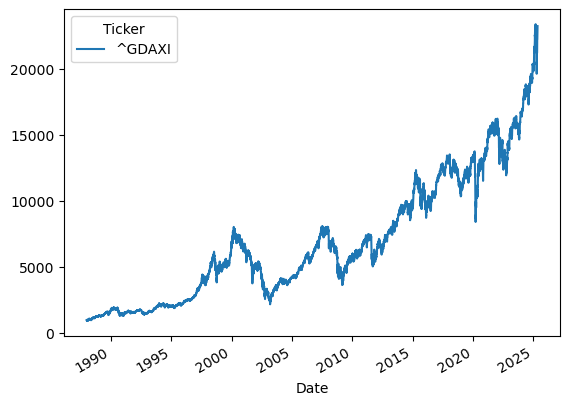

In [38]:
dax_data_daily = get_data_from_yahoo(ticker="^GDAXI", sampling_rate_days=1, save_path=DAILY_PRICES)

[*********************100%***********************]  1 of 1 completed


Coverage of downloaded data: 96.6%! Weekends and non-operating hours excluded. Can be due to holidays or missing data.


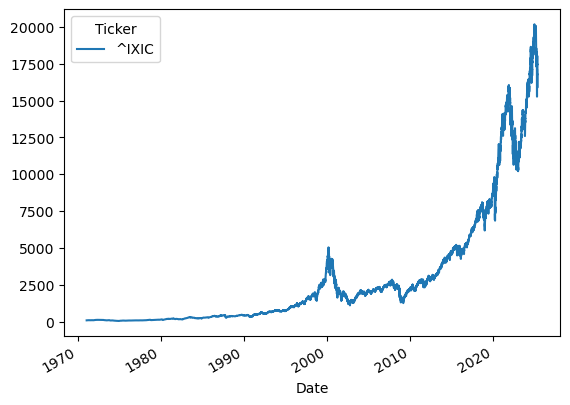

In [39]:
nasdaq_data_daily = get_data_from_yahoo(ticker="^IXIC", sampling_rate_days=1, save_path=DAILY_PRICES)

[*********************100%***********************]  1 of 1 completed


Coverage of downloaded data: 96.5%! Weekends and non-operating hours excluded. Can be due to holidays or missing data.


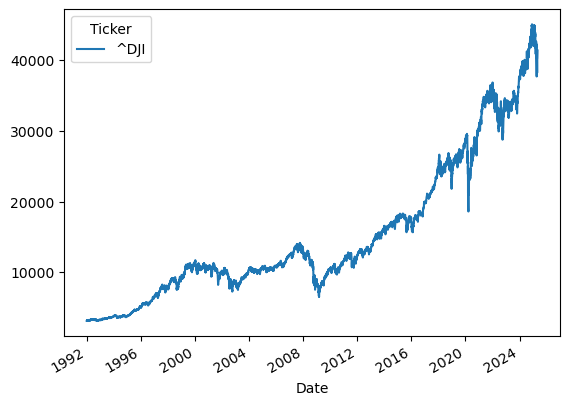

In [41]:
dowjones_data_daily = get_data_from_yahoo(ticker="^DJI", sampling_rate_days=1, save_path=DAILY_PRICES)

[*********************100%***********************]  1 of 1 completed


Coverage of downloaded data: 96.3%! Weekends and non-operating hours excluded. Can be due to holidays or missing data.


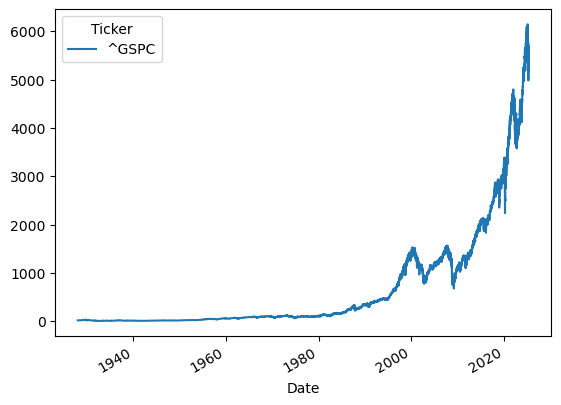

In [42]:
sp500_data_daily = get_data_from_yahoo(ticker="^GSPC", sampling_rate_days=1, save_path=DAILY_PRICES)

In [37]:
get_data_from_yahoo(ticker="^GSPC", sampling_rate_minutes=1)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

1 Failed download:
['^GSPC']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


IndexError: index 0 is out of bounds for axis 0 with size 0

## Download from AlphaVantage
(Restricted to 25 daily free requests)

In [29]:
def get_data_from_alphavantage(api_key: str,
                               ticker: str = 'DAX', start_year_month : (int, int) = None, end_year_month : (int, int) = None,
                               sampling_rate: Literal['1min', '5min', '15min', '30min', '60min'] = '1min',
                               price_column: Literal["1. open", "2. high", "3. low", "4. close"] = '4. close',
                               csv_path_to_concat: str = None,
                               save_path=None) -> pd.DataFrame:
    """
    Data downloader utilising alpha-vantage's API.

    :param ticker: string, default = "DAX" (DAX index)
        Specifies which stock's price data to download. Examples: "VCNIX" (Nasdaq)
    :param start_year_month: tuple (int, int), optional
        Amount of days to download data for. If not specified, downloads as much as possible.
    :param end_year_month: tuple (int, int), optional
        Amount of days to download data for. If not specified, downloads as much as possible.
    :param sampling_rate: str, default = "1min"
        Sampling rate of data. Options: '1min', '5min', '15min', '30min', '60min'
    :param price_column: str, default = "4. close"
        Which of the downloaded columns to utilise as price data. Options: "1. open", "2. high", "3. low", "4. close"
    :param csv_path_to_concat: str, optional
        Path to csv file from previous download which should be extended.
    :param save_path: str, optional
        File-title string defining repository where to save the downloaded data. If not provided, will not save the results.
        
    :return:
    """
    # if no end date specified download until start date:
    if start_year_month is not None and end_year_month is None:
        end_year_month = start_year_month
    
    # prepare month arguments for API queries:
    list_of_year_month_strings = []
    if start_year_month is not None:
        for year in range(start_year_month[0], end_year_month[0]+1):
            if year == start_year_month[0] and year == end_year_month[0]:  # if only one year
                for month in range(start_year_month[1], end_year_month[1]+1):
                    list_of_year_month_strings.append(f"{year}-{f'{month}' if month >= 10 else f'0{month}'}")
            elif year == start_year_month[0]:  # first year
                for month in range(start_year_month[1], 13):
                    list_of_year_month_strings.append(f"{year}-{f'{month}' if month >= 10 else f'0{month}'}")
            elif year == end_year_month[0]:  # last year
                for month in range(1, end_year_month[1]+1):
                    list_of_year_month_strings.append(f"{year}-{f'{month}' if month >= 10 else f'0{month}'}")
            else:  # other years
                for month in range(1, 13):
                    list_of_year_month_strings.append(f"{year}-{f'{month}' if month >= 10 else f'0{month}'}")
        if len(list_of_year_month_strings) > 25:
            raise ValueError(f"Specified time range would result in more than 25 API queries. This exceeds the daily limit and leads to errors.")
        else:
            print(f"Will query the AlphaVantage API {len(list_of_year_month_strings)} times based on the specified time range. Queries:\n", list_of_year_month_strings)
    else:
        print("No time range specified. Will download price data of last 30 days.")
        list_of_year_month_strings.append(None)
    
    # prepare dataframe or load existing one:
    if csv_path_to_concat is not None:
        price_frame = pd.read_csv(csv_path_to_concat)
        # set datetime as index:
        price_frame['date'] = pd.to_datetime(price_frame['date'])
        price_frame.set_index('date', inplace=True)
    else: price_frame = pd.DataFrame()
    
    # query and concat:
    for year_month in tqdm(list_of_year_month_strings):
        ts = TimeSeries(key=api_key, output_format='pandas')  # initialise time-series API
        try:  # query:
            temp_price_frame = ts.get_intraday(ticker, extended_hours=False, interval=sampling_rate, month=year_month, outputsize="full")[0]
            price_frame = pd.concat([price_frame, temp_price_frame])
        except ValueError as err:  # occurs if capacity for free queries is exhausted
            print(err)
    # sort the data according to datetimes and remove duplicates:
    price_frame.sort_index(inplace=True)
    price_frame.drop_duplicates(inplace=True)
    
    # save data:
    if save_path is not None:
        date_range_string = f"{price_frame.index.min().strftime('%Y-%m-%d')} to {price_frame.index.max().strftime('%Y-%m-%d')}"
        save_title = filemgmt.file_title(title=f"{ticker} {price_column} price data {date_range_string}", dtype_suffix=".csv")
        price_frame.to_csv(save_path / save_title)
    
    return price_frame

### Execution

In [32]:
get_data_from_alphavantage(AV_API_KEY, save_path=MINUTELY_PRICES, start_year_month=(2023, 11), end_year_month=(2023, 12), csv_path_to_concat=MINUTELY_PRICES / "20250507 16_55_10 DAX 4. close price data 2023-07-03 to 2025-04-30.csv")

Will query the AlphaVantage API 6 times based on the specified time range. Queries:
 ['2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12']


100%|██████████| 6/6 [00:03<00:00,  1.67it/s]

We have detected your API key as HD7J9N2ADQ3FS4Q5 and our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.
We have detected your API key as HD7J9N2ADQ3FS4Q5 and our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.


,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2023-07-03 09:19:00,29.4101,29.4101,29.4101,29.4101,1.0
2023-07-03 09:30:00,28.7383,28.7383,28.7383,28.7383,1616.0
2023-07-03 09:39:00,28.7019,28.7019,28.7019,28.7019,122.0
2023-07-03 11:40:00,28.6410,28.6410,28.6410,28.6410,195.0
2023-07-03 11:51:00,28.7189,28.7189,28.7189,28.7189,100.0
...,...,...,...,...,...
2025-04-30 17:13:00,41.9000,41.9000,41.9000,41.9000,5.0
2025-04-30 18:00:00,41.5582,41.5582,41.5582,41.5582,50.0
2025-04-30 18:09:00,41.5100,41.5100,41.5100,41.5100,3.0


### REPEAT FOR (2023, 11) to (2023, 12) because free queries were exhausted

In [28]:
price_frame = pd.read_csv(MINUTELY_PRICES / "20250507 16_49_07 DAX 4. close price data 2024-11-01 to 2024-12-31.csv")
price_frame['date'] = pd.to_datetime(price_frame['date'])
price_frame.set_index('date', inplace=True)
price_frame.drop_duplicates()

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2024-11-01 09:30:00,33.8483,33.8483,33.8483,33.8483,499.0
2024-11-01 10:29:00,33.8084,33.8084,33.8084,33.8084,238.0
2024-11-01 10:58:00,33.8084,33.8084,33.8084,33.8084,1630.0
2024-11-01 13:34:00,33.8084,33.8084,33.8084,33.8084,111.0
2024-11-01 13:46:00,33.8084,33.8084,33.8084,33.8084,100.0
...,...,...,...,...,...
2024-12-31 13:19:00,33.2900,33.2900,33.2900,33.2900,100.0
2024-12-31 14:59:00,33.2800,33.2800,33.2800,33.2800,111.0
2024-12-31 15:23:00,33.3200,33.3200,33.3199,33.3199,450.0
